#### Main functions

In [ ]:
import numpy as np
from scipy.stats import random_correlation
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

np.random.seed(2048)

def generate_X(depth, mean_X, sigma_X):
    return np.random.multivariate_normal(mean_X, sigma_X, depth)

def generate_y(depth, mean_y, sigma_y):
    return sigma_y * np.random.randn(depth) + mean_y

def simplex_sampling(nstocks):
    samples = np.random.exponential(scale = 1.0, size = nstocks)
    return samples / sum(samples)

# We use cvxopt to solve the quadratic problem
def qp_solver(X, y):
    depth, nstocks = X.shape

    # utility function 1/2 * w.T * Q * w + w.T * p
    Q = matrix(np.matmul(X.T, X))
    p = matrix(-np.matmul(X.T, y))

    # inequality constraints w.T * G <= h
    G = matrix(-np.eye(nstocks))
    h = matrix(np.zeros(nstocks))

    # equality constraints w.T * A = b
    A = matrix(np.array([np.ones(nstocks)]))
    b = matrix(1.0)

    solvers.options['show_progress'] = False
    return solvers.qp(Q, p, G, h, A, b)

#### Some helpers for plot and tracking error

In [2]:
def tracking_error(portf_weights, X, y):
    return np.linalg.norm(np.matmul(X, portf_weights).reshape(-1) - y) ** 2 / X.shape[0]

def visualize_data(X, mean_X, sigma_X, y, mean_y, sigma_y):
    # some sanity check
    depth, nstocks = X.shape
    legends = ['R' + str(i) for i in range(1,nstocks + 1)]
    legends.append('y')

    print(f'X:\t mean_X = {mean_X}\t sample mean = {np.mean(X, axis = 0)}')
    print(f'\t sigma_X = {sigma_X}\t stdev = {np.std(X, axis = 0)}')

    print(f'y:\t mean_y = {mean_y}\t sample mean = {y.mean()}')
    print(f'\t sigma_y = {sigma_y} \t stdev = {y.std()}')

    plt.hist(y, bins = depth // 10)
    plt.title('Index return distribution')

    # plt.figure(figsize = (12, 5))
    # plt.plot(X)
    # plt.plot(y, label='y')
    # plt.legend(legends, loc='upper left')
    # plt.title('Returns')

    plt.figure(figsize = (12, 5))
    plt.plot(np.cumprod(X/100 + 1, axis=0))
    plt.plot(np.cumprod(y/100 + 1), label='y')
    plt.legend(legends, loc='upper left')
    plt.title('Cumulative returns')
    plt.show()

def plot_output(portf_weights, X, y):
    depth, nstocks = X.shape
    legends = ['R' + str(i) for i in range(1,nstocks + 1)]

    error = tracking_error(portf_weights, X, y)
    print(f'Portfolio: {np.array(portf_weights).reshape(-1)}\nTracking error: {error}')

    plt.figure(figsize = (12, 5))
    plt.bar(legends, portf_weights, color ='maroon', width = 0.4)
    plt.title('Portfolio weights')

    portf_returns = X.dot(portf_weights)
    index_returns = y

    plt.figure(figsize=(12,5))
    plt.plot(portf_returns, color='red', label='portf returns')
    plt.plot(index_returns, color='blue', label='index returns')
    plt.legend(loc='upper left')

    portf_cumulative_returns = np.cumprod(portf_returns/100 + 1)
    index_cumulative_returns = np.cumprod(y/100 + 1)
    diff_returns = index_cumulative_returns - portf_cumulative_returns

    plt.figure(figsize=(12,5))
    plt.plot(portf_cumulative_returns, color='red', label='portf cumulative')
    plt.plot(index_cumulative_returns, color='blue', label='index cumulative')
    plt.plot(diff_returns, color='black', label='diff')
    plt.legend(loc='upper left')
    plt.show()

#### Generate data
Increasing `depth` and `nstocks` should show visually a better fit.

We can mutate the volatility `std_X` to see the behavior of optimization changes. 
Intuitively, higher volatility of stocks should increase cumulative tracking error (as the portfolio return fluctuates more). However, in this case, sample mean and covariance of `X` are not closed to the input parameters.

In [3]:
depth = 100
nstocks = 5

In [4]:
mean_X = np.random.uniform(low = -0.5, high = 2, size = nstocks)
# low volatility regime
std_X = np.diag(np.random.uniform(low = 1, high = 2, size = nstocks))

eigs = simplex_sampling(nstocks) * nstocks # (.5, .8, 1, 1.2, 1.5)
correl_X = random_correlation.rvs(eigs)
sigma_X = std_X.dot(correl_X.dot(std_X))

In [5]:
mean_y = np.random.uniform(low = 0, high = 1)
sigma_y = np.random.uniform(low = 0.5, high = 2)

X:	 mean_X = [ 0.97403111 -0.15798366  1.15507218  1.96782064  1.74364962]	 sample mean = [1.18145528 0.02565647 1.15046119 1.80228486 1.60231406]
	 sigma_X = [[ 2.49309804 -0.26940511  0.25705691 -0.86090399 -0.77446402]
 [-0.26940511  1.13398962  0.09470913 -0.41742125 -0.48178503]
 [ 0.25705691  0.09470913  1.22884456  0.55379405 -1.10858352]
 [-0.86090399 -0.41742125  0.55379405  2.09534274  0.37090779]
 [-0.77446402 -0.48178503 -1.10858352  0.37090779  1.79151044]]	 stdev = [1.69857479 0.95167707 1.04276574 1.57757407 1.23610643]
y:	 mean_y = 0.8784303321554203	 sample mean = 0.86401306885172
	 sigma_y = 1.8926095632381517 	 stdev = 2.065868062426679


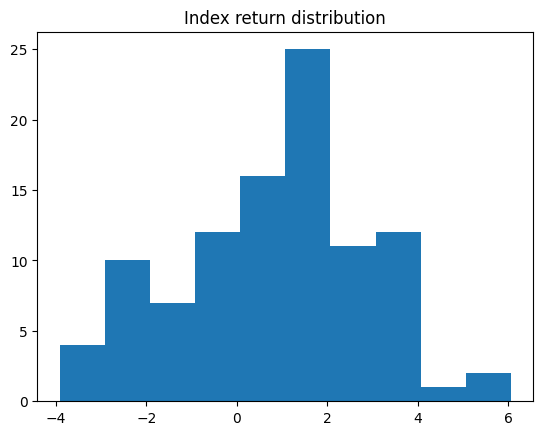

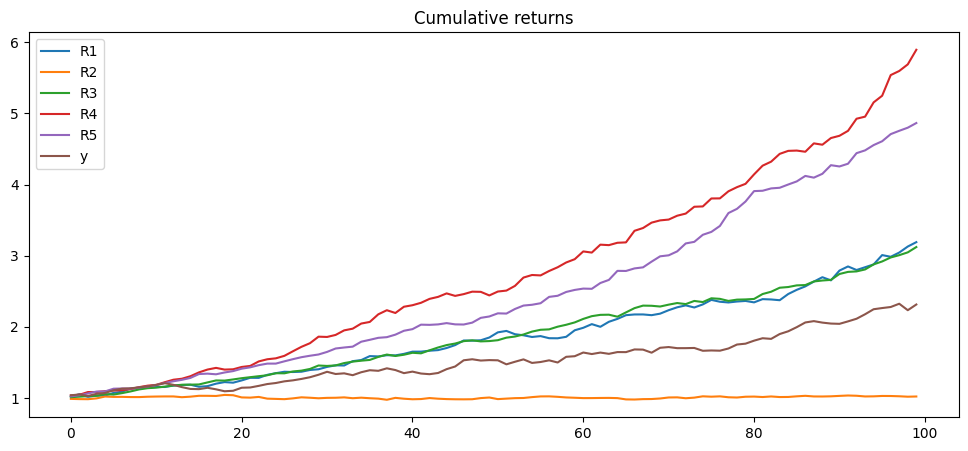

In [6]:
X = generate_X(depth, mean_X, sigma_X)
y = generate_y(depth, mean_y, sigma_y)
visualize_data(X, mean_X, sigma_X, y, mean_y, sigma_y)

#### Solve the quadratic problem
Even though the porfolio minimizes the sum of squares of daily return difference, there can be an effect of bad cumulative tracking error (which may depend on the volatility between stocks and index).

Portfolio: [0.21942056 0.14867714 0.28884336 0.13562088 0.20743806]
Tracking error: 4.154432347647319


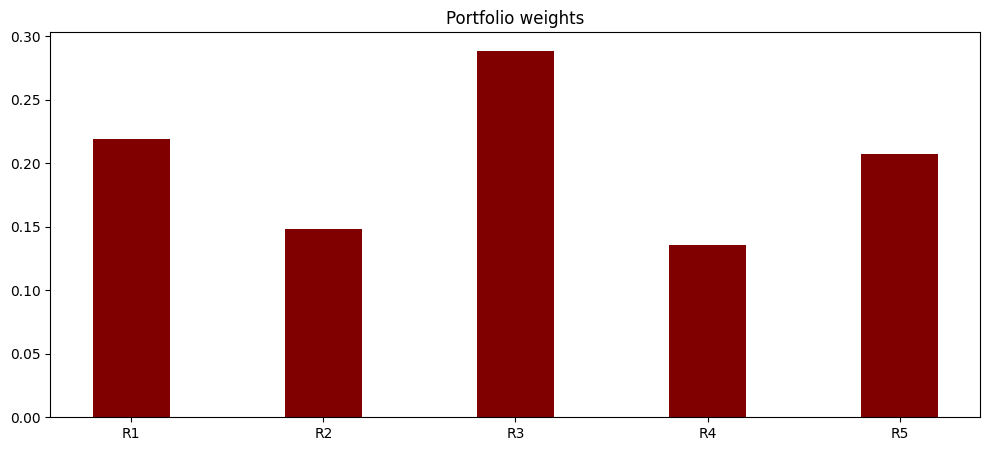

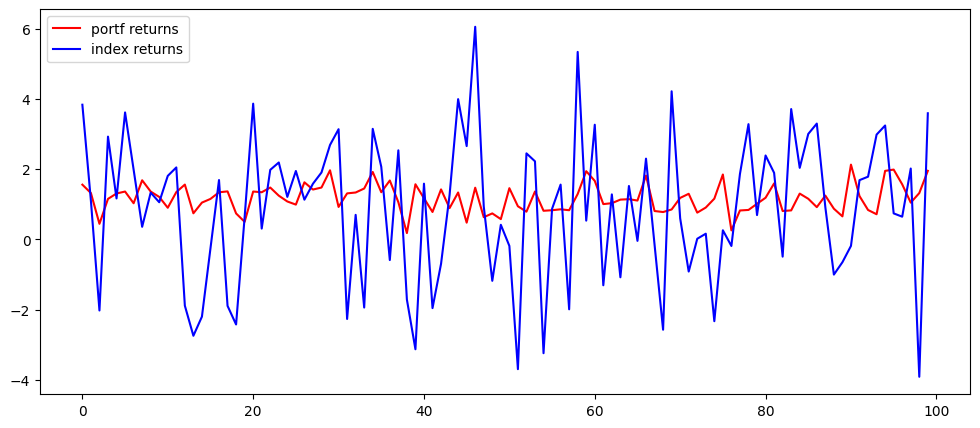

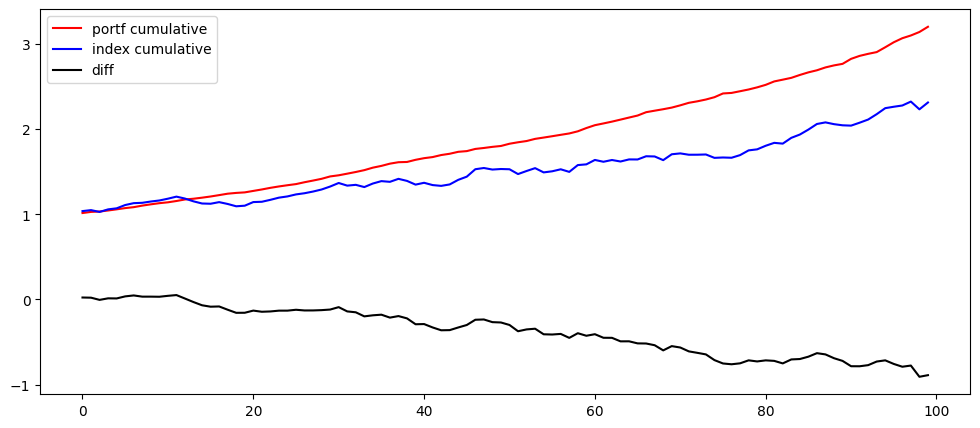

In [7]:
portf_weights = qp_solver(X, y)['x']
plot_output(portf_weights, X, y)

#### Sample some random portfolios for sanity check
I sampled 1000 random portfolios from the simplex of `nstocks` dimension. The smalles tracking error among these portfolios should be larger (but quite close) than the minimum tracking error above.

Portfolio: [0.17942063 0.14278988 0.32538625 0.0945296  0.25787364]
Tracking error: 4.1605465073477825


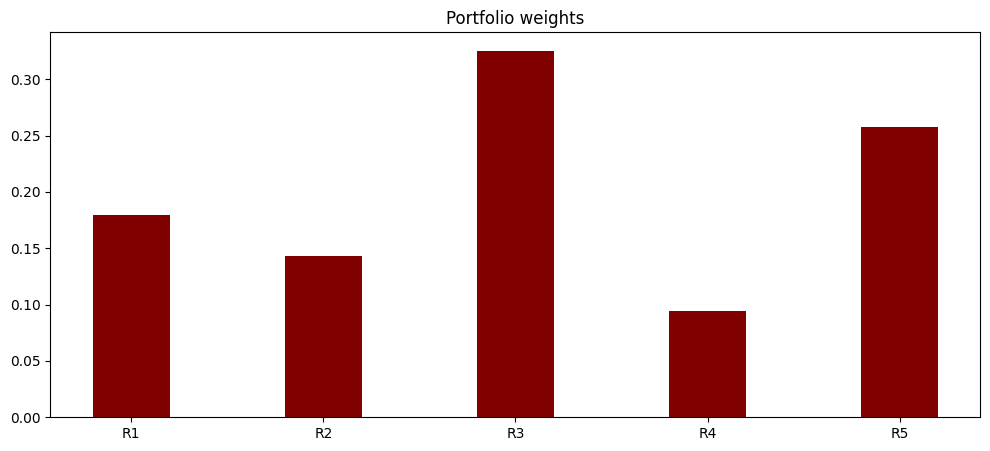

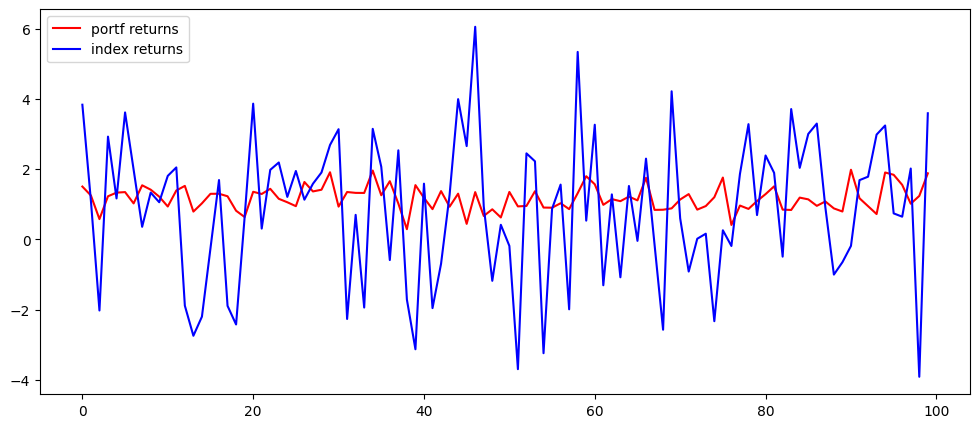

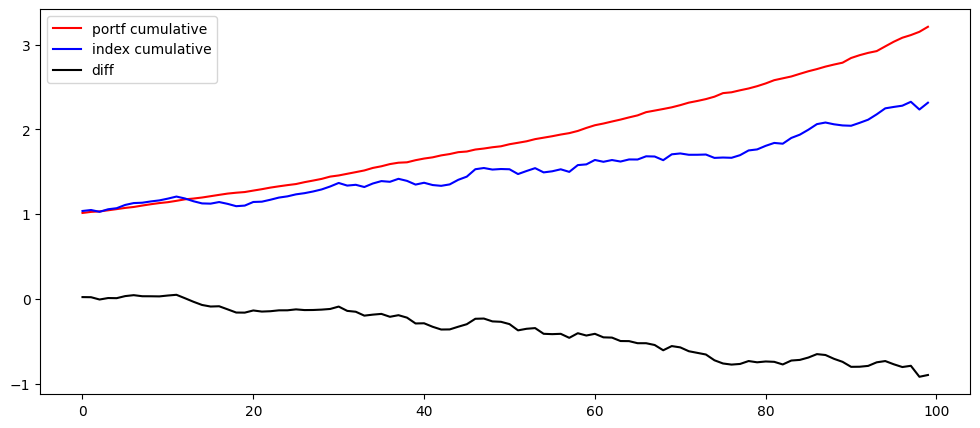

In [8]:
portfolios = []
weights = []
for i in range(1000):
    sample = simplex_sampling(nstocks)
    portfolios.append(sample)
    weights.append(tracking_error(sample, X, y))

idx = weights.index(min(weights))
sampled_portfolio = portfolios[idx]
plot_output(sampled_portfolio, X, y)

### High volatility regime
We keep `y`, `correl_X` unchanged and generate a new `X` with higher stdev. Then, by doing some simulation, we observe that it is more difficult to track the index in this case.

X:	 mean_X = [ 1.45401907  1.59581627  0.01200617  0.61959948 -0.23583828]	 sample mean = [ 0.36758742  2.27448877 -0.27866461  1.44061568 -0.51493026]
	 sigma_X = [[ 236.02970326  -22.4525956    30.62386213  -53.36592506  -74.77259059]
 [ -22.4525956    83.1961523     9.93244039  -22.77808985  -40.94754952]
 [  30.62386213    9.93244039  184.21755177   43.1977353  -134.68306065]
 [ -53.36592506  -22.77808985   43.1977353    85.04453457   23.44710102]
 [ -74.77259059  -40.94754952 -134.68306065   23.44710102  176.39018036]]	 stdev = [16.47385576  8.99515196 13.98030573 10.6113878  14.10656433]
y:	 mean_y = 0.8784303321554203	 sample mean = 0.86401306885172
	 sigma_y = 1.8926095632381517 	 stdev = 2.065868062426679


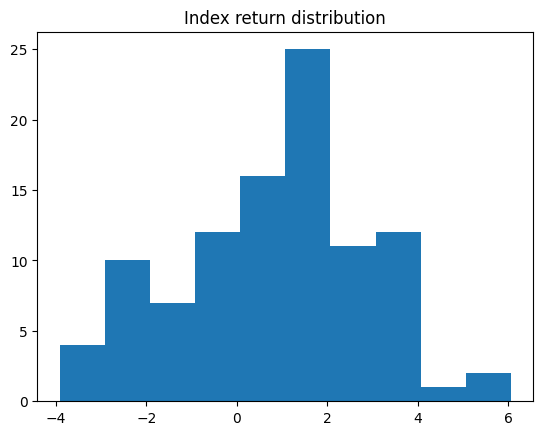

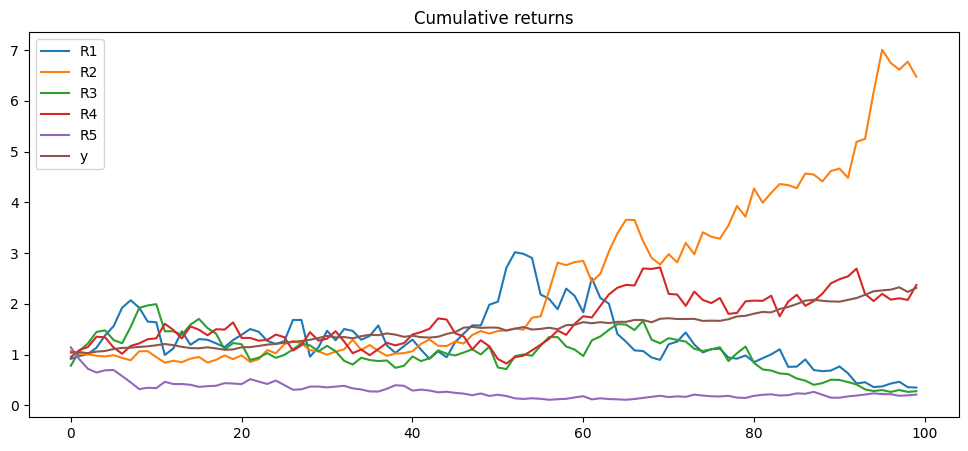

Portfolio: [1.45141619e-01 2.29827832e-01 2.69835774e-01 9.26331503e-07
 3.55193849e-01]
Tracking error: 12.611385069809025


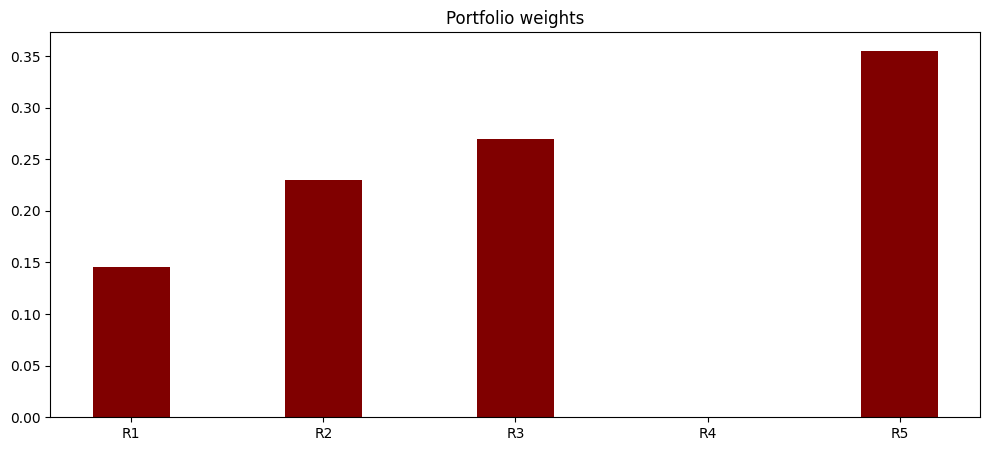

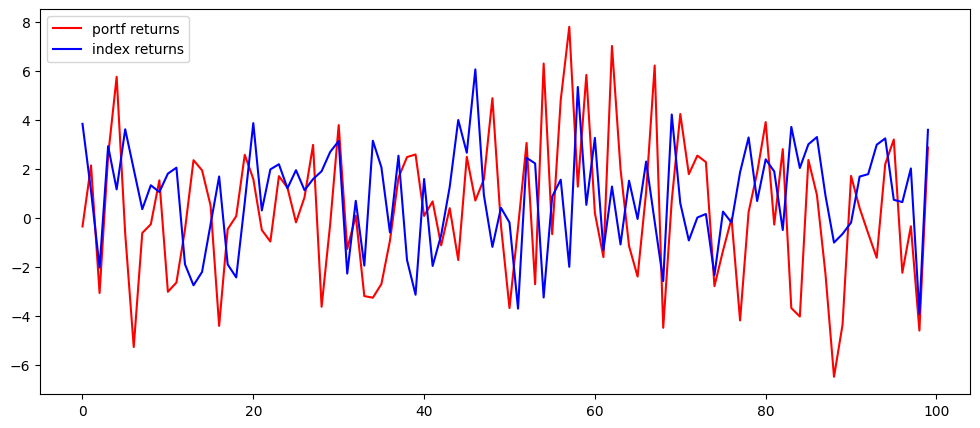

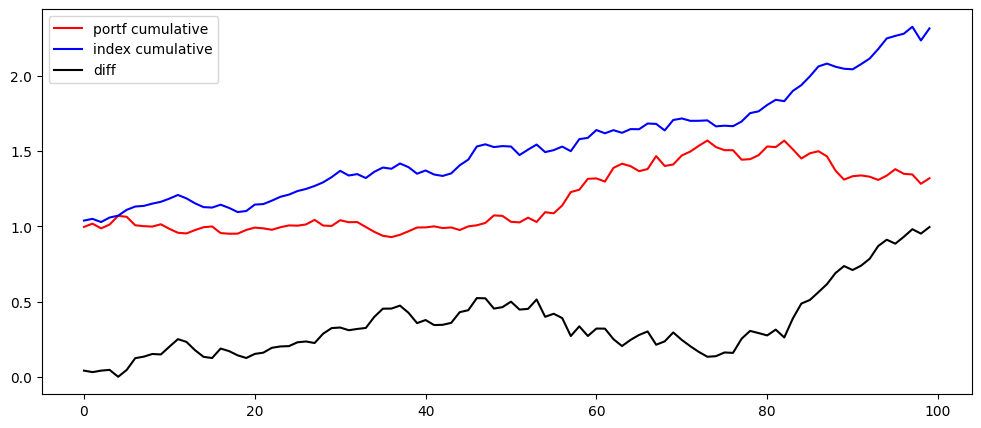

In [9]:
mean_X_high = np.random.uniform(low = -0.5, high = 2, size = nstocks)
# high volatility regime
std_X_high = np.diag(np.random.uniform(low = 8, high = 16, size = nstocks))
sigma_X_high = std_X_high.dot(correl_X.dot(std_X_high))

X_high = generate_X(depth, mean_X_high, sigma_X_high)
visualize_data(X_high, mean_X_high, sigma_X_high, y, mean_y, sigma_y)
portf_weights_high = qp_solver(X_high, y)['x']
plot_output(portf_weights_high, X_high, y)

Simulate 1000 `X`

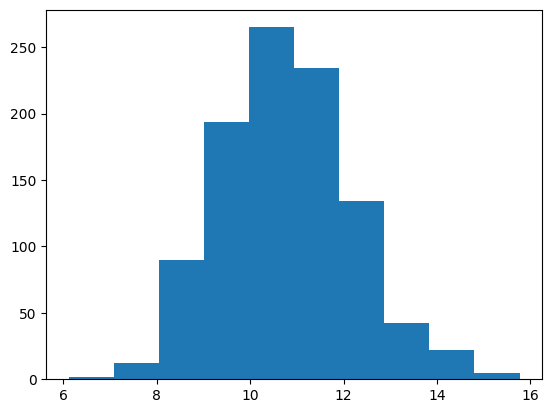

In [10]:
tracking_errors = []
for i in range(1000):
    X_sim = generate_X(depth, mean_X_high, sigma_X_high)
    portf_weights_sim = qp_solver(X_sim, y)['x']
    tracking_errors.append(tracking_error(portf_weights_sim, X_sim, y))

plt.hist(tracking_errors, bins=10)
plt.show()